<a href="https://colab.research.google.com/github/nmhaaa3218/CV-Facial-Expression/blob/main/Facial_Expression_Recognition_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Expression Recognition Competition (30%)**
For this competition, we will use the a facial classification dataset. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

We provide baseline code that includes the following features:

*   Loding and Analysing the FER-2013 dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following changes could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]


In [4]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: Manh Ha Nguyen, Le Thuy An Phan
### Student ID: a1840406, a1874923
### Comptetion Name: Facial Expression Recognition/Classification
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

# Set Up

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Importing libraries.

import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from tqdm import tqdm
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [3]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
# data_directory ='/content/drive/MyDrive/Datasets/fer2013/fer2013.csv'

In [4]:
# Reading the dataset file using Pandas read_csv function and print the first
# 5 samples.
#
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
data_df = pd.read_csv("fer2013.csv")
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [5]:
# Mapping of the Facial Expression Labels.
Labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
Labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [6]:
# Categorizing the dataset to three categories.
# Training: To train the model.
# PrivateTest: To test the train model; commonly known as Validation.
# PublicTest: To test the final model on Test set to check how your model perfomed. Do not use this data as your validation data.
train_df = data_df[data_df['Usage']=='Training']
valid_df = data_df[data_df['Usage']=='PublicTest']
test_df = data_df[data_df['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [7]:
# Test-check to see wether usage labels have been allocated to the dataset/not.
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [8]:
# Preview of the training sample and associated labels.
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

expression:  emotion                                                    0
pixels     179 175 176 170 149 136 129 118 105 91 87 81 7...
Usage                                               Training
Name: 107, dtype: object
(1, 2304)


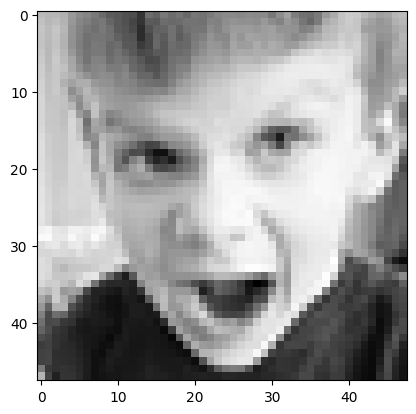

In [9]:
show_example(train_df, 107)

In [10]:
# Normalization of the train and validation data.
class expressions(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        #image = image.reshape(1,48,48)
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
        #image = np.reshape(image,(1,48,48))


        if self.transforms:
            image = self.transforms(image)

        return image.clone().detach(), label

In [11]:
#import albumentations as A
stats = ([0.5],[0.5])

In [12]:
train_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True),
])
valid_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True)
])

In [13]:
train_ds = expressions(train_df, train_tsfm)
valid_ds = expressions(valid_df, valid_tsfm)
test_ds = expressions(test_df, valid_tsfm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


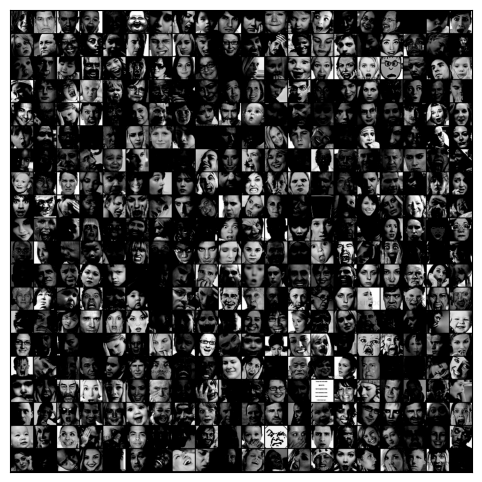

In [14]:
batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=0, pin_memory=False)
valid_dl = DataLoader(valid_ds, batch_size*2,
                    num_workers=0, pin_memory=False)
test_dl = DataLoader(test_ds, batch_size*2,
                    num_workers=0, pin_memory=False)
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

show_batch(train_dl)

In [15]:
# Evaluation metric - Accuracy in this case.

import torch.nn.functional as F
input_size = 48*48
output_size = len(Labels)

def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [16]:
# Expression model class for training and validation purpose.

class expression_model(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_default_device()
print(f'You are training on: {device}.')

You are training on: mps.


In [18]:
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    # Only use non_blocking on CUDA, not MPS
    return data.to(device, non_blocking=(device.type == 'cuda'))

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [20]:
# Functions for evaluation and training.
import numpy as np
import scipy.stats


@torch.no_grad()
def evaluate(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

# evaluate using reciporical rank fusion for multi model ensemble
@torch.no_grad()
def evaluate_rrf(models, valid_dl, weights=None):
    """
    Evaluate ensemble of models using Reciprocal Rank Fusion
    
    Args:
        models: List of trained models
        valid_dl: Validation dataloader
        weights: List of weights for each model (optional, defaults to equal weights)
    
    Returns:
        Dictionary with validation loss and accuracy
    """
    if weights is None:
        weights = [1.0] * len(models)
    
    # Set all models to evaluation mode
    for model in models:
        model.eval()
    
    # Get predictions from each model for ensemble
    all_scores = []
    all_losses = []
    true_labels = []
    
    for i, model in enumerate(models):
        predictions = []
        scores = []
        losses = []
        
        for batch in valid_dl:
            images, batch_labels = batch
            images = images.to(device)
            
            # Get model outputs and validation step
            val_result = model.validation_step(batch)
            losses.append(val_result['val_loss'])
            
            outputs = model(images)
            batch_scores = F.softmax(outputs, dim=1)
            scores.append(batch_scores.cpu().numpy())
            
            # Collect true labels only once
            if i == 0:
                true_labels.extend(batch_labels.cpu().numpy())
        
        all_scores.append(np.concatenate(scores))
        all_losses.append(torch.stack(losses).mean().item())
    
    true_labels = np.array(true_labels)
    
    # Reciprocal Rank Fusion with weights
    k = 60  # fusion parameter
    fused_scores = np.zeros_like(all_scores[0])
    
    for i, scores in enumerate(all_scores):
        # Convert probabilities to ranks (highest prob = rank 1)
        ranks = np.zeros_like(scores)
        for j in range(len(scores)):
            ranks[j] = len(scores[j]) - scipy.stats.rankdata(scores[j]) + 1
        
        # Apply weighted reciprocal rank formula
        fused_scores += weights[i] * (1 / (k + ranks))
    
    # Get final predictions from fused scores
    final_predictions = np.argmax(fused_scores, axis=1)
    
    # Calculate ensemble metrics
    ensemble_accuracy = np.mean(final_predictions == true_labels)
    ensemble_loss = np.mean(all_losses)  # Average of individual model losses
    
    return {
        'val_loss': ensemble_loss,
        'val_acc': ensemble_accuracy
    }


def fit(epochs, lr, model, train_dl, valid_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
# Plots for accuracy and loss during training period.
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [22]:
# Prediction function to evaluate the model.
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return Labels[preds[0].item()]

In [23]:
# Count number of parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Baseline Models

In [ ]:
# Basic model - 1 layer
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.to(device)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

In [27]:
# Model - 7 layer
class expression(expression_model):
    def __init__(self,classes):
        super().__init__()
        self.num_classes = classes
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(),
            nn.Linear(256*6*6, 2304),
            nn.ReLU(),
            nn.Linear(2304, 1152),
            nn.ReLU(),
            nn.Linear(1152, 576),
            nn.ReLU(),
            nn.Linear(576,288),
            nn.ReLU(),
            nn.Linear(288,144),
            nn.ReLU(),
            nn.Linear(144,self.num_classes))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
# Model print
model = to_device(expression(classes = 7), device)
print(count_params(model))
print(model)

In [ ]:
evaluate(model, valid_dl)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
# Model evaluation on test data.
result = evaluate(model, test_dl)
result

In [ ]:
img, label = test_ds[0]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_ds[110]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

##FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [ ]:
# we use fvcore to calculate the FLOPs
# !pip install fvcore

In [ ]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 1, 48, 48) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 7
model = expression(num_classes)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

In [ ]:
# Calculate efficiency for baseline
efficiency = 0.5513560771942139/0.32751
efficiency

# Experiment with ResEmoteNet

In [29]:
# ——— SE and Residual blocks ———
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        # if shape changes, match it with a 1×1 conv
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        return F.relu(out)


# ——— Integrated model ———
class ResExpressionModel(expression_model):
    def __init__(self, num_classes, in_channels=1):
        super().__init__()
        # initial conv layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(256)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)

        # squeeze‐and‐excitation
        self.se = SEBlock(256)

        # residual layers
        self.res1 = ResidualBlock(256, 512, stride=2)
        self.res2 = ResidualBlock(512, 1024, stride=2)
        self.res3 = ResidualBlock(1024, 2048, stride=2)

        # classifier head
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Stem
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # SE
        x = self.se(x)

        # Residual stacks
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        # Head
        x = self.global_pool(x)              # [B, 2048, 1, 1]
        x = x.view(x.size(0), -1)            # [B, 2048]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [ ]:
model_ree = to_device(ResExpressionModel(num_classes = 7, in_channels=1), device)
print(count_params(model_ree))
print(model_ree)

In [ ]:
num_epochs = 30
opt_func = torch.optim.AdamW
lr = 0.001
history = fit(num_epochs, lr, model_ree, train_dl, valid_dl, opt_func)

In [ ]:
plot_accuracies(history)


In [ ]:
plot_losses(history)

In [ ]:
# Model evaluation on test data.
result = evaluate(model_ree, test_dl)
result

In [ ]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 1, 48, 48) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 7
model = ResExpressionModel(num_classes=num_classes,in_channels=1)
model.eval()
flops = FlopCountAnalysis(model, input)
flops_value = flops.total()/1e9
print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

acc = result.get("val_acc")
print("Accuracy: ", acc)
eff_score = acc/flops_value
print("Efficiency: ", eff_score)

# Vision Transformer

In [24]:
class VisionTransformer(expression_model):
    def __init__(self,
                 img_size: int = 48,
                 patch_size: int = 6,
                 in_chans: int = 1,
                 num_classes: int = 7,
                 embed_dim: int = 256,
                 depth: int = 6,
                 num_heads: int = 8,
                 mlp_ratio: float = 2.0,
                 dropout: float = 0.1):
        super().__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by patch size"
        num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_chans, embed_dim,
                                     kernel_size=patch_size,
                                     stride=patch_size)
        # class token + positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        # build Transformer encoder
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_hidden_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # initialize
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: [B, 1, 48, 48]
        B = x.size(0)
        # patch embedding -> [B, E, P, P]  where P=img_size/patch_size
        x = self.patch_embed(x)
        # flatten patches
        x = x.flatten(2).transpose(1, 2) # ORIGNAL ON CUDA
        
        # prepend cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, E]
        x = torch.cat((cls_tokens, x), dim=1)          # [B, 1+num_patches, E]
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Transformer
        x = self.encoder(x)            # [B, 1+num_patches, E]
        x = self.norm(x)
        cls_out = x[:, 0]              # take cls token
        return self.head(cls_out)      # [B, num_classes]




In [ ]:
# 3) Instantiate, move to device, and train just like your other models
model_vit = VisionTransformer(
    img_size=48,
    patch_size=6,
    in_chans=1,
    num_classes=7,
    embed_dim=1280,
    depth=6,
    num_heads=1280//64,
    mlp_ratio=2.0,
    dropout=0.1
)
model_vit = to_device(model_vit, device)
print(count_params(model_vit))
print(model_vit)

In [ ]:
# 4) Train / validate
num_epochs = 20
lr = 1e-3
history_vit = fit(num_epochs, lr, model_vit, train_dl, valid_dl, opt_func=torch.optim.AdamW)

In [ ]:
# 5) Plot its curves
plot_accuracies(history_vit)



In [ ]:
plot_losses(history_vit)

In [ ]:
# 6) Final evaluation on the test set
result_vit = evaluate(model_vit, test_dl)
print("Test result:", result_vit)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops = FlopCountAnalysis(model_vit.eval(), dummy_input)
gflops = flops.total() / 1e9
acc = result_vit['val_acc']
efficiency = acc / gflops
print(f"ViT GFLOPs: {gflops}")
print(f"ViT Accuracy: {acc}")
print(f"ViT Efficiency: {efficiency}")

# EfficientNetV2 M



In [24]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torch import nn
import torch.nn.functional as F

class EfficientNetV2M(expression_model):
    def __init__(self, number_of_class: int, in_channel: int = 1):
        super().__init__()

        # ---- backbone (no weights) -----------------------------------------
        self.model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights)
        # self.model = efficientnet_v2_s(weights=None)

        # ---- replace stem for 1-channel input ------------------------------
        # features[0] = ConvNormActivation(conv, bn, silu)
        old_conv = self.model.features[0][0]          # nn.Conv2d
        self.model.features[0][0] = nn.Conv2d(
            in_channels   = in_channel,
            out_channels  = old_conv.out_channels,    # 24
            kernel_size   = old_conv.kernel_size,
            stride        = old_conv.stride,
            padding       = old_conv.padding,
            bias=False
        )

        # ---- replace classifier head ---------------------------------------
        in_feat = self.model.classifier[1].in_features  # 1280 for v2-s
        self.model.classifier[1] = nn.Linear(in_feat, number_of_class)

    # -----------------------------------------------------------------------
    def forward(self, x):
        return self.model(x)        # returns logits (batch, num_classes)

model_eff_2m = to_device(EfficientNetV2M(7,1),device)
print(count_params(model_eff_2m))
print(model_eff_2m)

52866891
EfficientNetV2M(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): B

In [25]:
# ─────────────────────────────────────────────────────────────────────────────
#  EfficientNetV2-M  ⟶  optimised training loop (FER-2013)
# ─────────────────────────────────────────────────────────────────────────────
import math, torch

# ── Balanced Hyper-parameters ─────────────────────────────────────────────
epochs_eff_2m        = 150        # down from 350, up from 100
batch_size_eff_2m    = 32         # reduced batch size for larger model
base_lr_eff_2m       = 3e-4       # lower LR for larger model
max_lr_eff_2m        = 2e-3       # reduced max LR for stability
weight_decay_eff_2m  = 0.08       # slightly lower than 0.1 to ease regularization
label_smooth_eff_2m  = 0.1
grad_clip_norm       = 5.0
patience_eff_2m      = 15         # tighter early-stop than 30, looser than 10

# ❷  Optimiser – parameter-wise weight-decay split with layer-wise params
decay, no_decay = [], []
for n, p in model_eff_2m.named_parameters():
    if not p.requires_grad: continue
    # Skip weight decay for biases, LayerNorm and position embeddings
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_eff_2m = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_eff_2m},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_eff_2m, betas=(0.9, 0.999), eps=1e-8  # adjusted beta2 and eps
)

# ❸  Cosine scheduler with longer warmup
sched_eff_2m = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_eff_2m,
    max_lr          = max_lr_eff_2m,
    epochs          = epochs_eff_2m,
    steps_per_epoch = len(train_dl),
    pct_start       = 0.15,       # 10% warmup period
    div_factor      = 8,        # reduced LR range
    final_div_factor= 500
)

# ❺  Training loop with early-stop and checkpoint
best_val_acc_eff_2m   = 0.0
epochs_no_imp_eff_2m  = 0
history_eff_2m        = []

for epoch in range(epochs_eff_2m):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_2m.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_2m.training_step(batch)       # CE + smooth inside
        train_losses.append(loss.detach())
        loss.backward()

        # clip gradients *before* stepping
        torch.nn.utils.clip_grad_norm_(model_eff_2m.parameters(), grad_clip_norm)

        optimizer_eff_2m.step()
        optimizer_eff_2m.zero_grad(set_to_none=True)  # more efficient zero_grad
        sched_eff_2m.step()

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_2m, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_2m.epoch_end(epoch, result)                  # prints nicely
    history_eff_2m.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_eff_2m:
        best_val_acc_eff_2m, epochs_no_imp_eff_2m = val_acc, 0
        torch.save(model_eff_2m.state_dict(), 'model_efficientnetv2m_best.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_eff_2m += 1
        if epochs_no_imp_eff_2m >= patience_eff_2m:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_eff_2m} epochs).")
            break


Epoch[0], val_loss: 1.6422, val_acc: 0.3579
→ New best val_acc = 0.3579  (ckpt saved)
Epoch[1], val_loss: 1.3452, val_acc: 0.4769
→ New best val_acc = 0.4769  (ckpt saved)
Epoch[2], val_loss: 1.2882, val_acc: 0.5229
→ New best val_acc = 0.5229  (ckpt saved)
Epoch[3], val_loss: 1.2924, val_acc: 0.5334
→ New best val_acc = 0.5334  (ckpt saved)
Epoch[4], val_loss: 1.4880, val_acc: 0.5387
→ New best val_acc = 0.5387  (ckpt saved)
Epoch[5], val_loss: 1.5653, val_acc: 0.5501
→ New best val_acc = 0.5501  (ckpt saved)
Epoch[6], val_loss: 18.5184, val_acc: 0.5330
Epoch[7], val_loss: 1.6535, val_acc: 0.5504
→ New best val_acc = 0.5504  (ckpt saved)
Epoch[8], val_loss: 1.5764, val_acc: 0.5622
→ New best val_acc = 0.5622  (ckpt saved)
Epoch[9], val_loss: 1.6062, val_acc: 0.5639
→ New best val_acc = 0.5639  (ckpt saved)
Epoch[10], val_loss: 1.4536, val_acc: 0.5624
Epoch[11], val_loss: 1.8059, val_acc: 0.5627
Epoch[12], val_loss: 1.5736, val_acc: 0.5604
Epoch[13], val_loss: 1.5534, val_acc: 0.5680
→

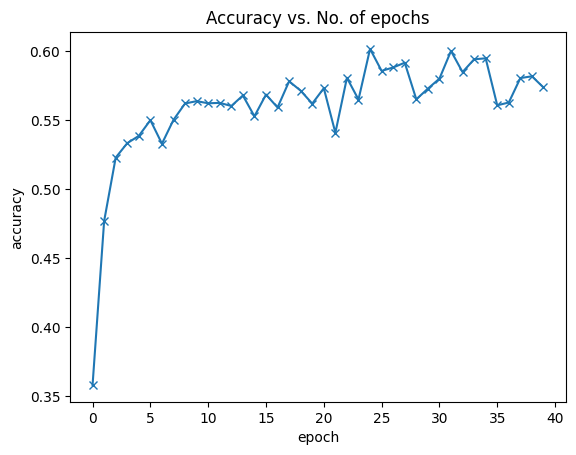

In [26]:
plot_accuracies(history_eff_2m)


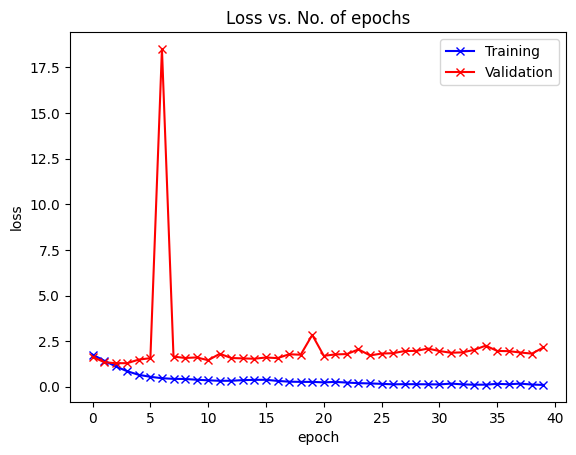

In [27]:
plot_losses(history_eff_2m)


In [29]:
from fvcore.nn import FlopCountAnalysis
# ────────── final test ────────────────────────────────────────────────────────
model_eff_2m.load_state_dict(torch.load('model_efficientnetv2m_best.pth'))

# 6) Final evaluation on the test set
result_eff_test = evaluate(model_eff_2m, test_dl)
print("EfficientNetV2-M Test result:", result_eff_test)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops_eff = FlopCountAnalysis(model_eff_2m.eval(), dummy_input)
gflops_eff = flops_eff.total() / 1e9
acc_eff = result_eff_test['val_acc']
efficiency_eff = acc_eff / gflops_eff
print(f"EfficientNetV2-M GFLOPs: {gflops_eff}")
print(f"EfficientNetV2-M Accuracy: {acc_eff}")
print(f"EfficientNetV2-M Efficiency: {efficiency_eff}")

EfficientNetV2-M Test result: {'val_loss': 1.738285779953003, 'val_acc': 0.6001953482627869}


Unsupported operator aten::silu_ encountered 147 time(s)
Unsupported operator aten::add_ encountered 51 time(s)
Unsupported operator aten::sigmoid encountered 44 time(s)
Unsupported operator aten::mul encountered 44 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
model.features.1.0.stochastic_depth, model.features.1.1.stochastic_depth, model.features.1.2.stochastic_depth, model.features.2.0.stochastic_depth, model.features.2.1.stochastic_depth, model.features.2.2.stochastic_depth, model.features.2.3.stochastic_depth, model.features.2.4.stochastic_depth, model.features.3.0.stochastic_depth, model.features.3.1.stochastic_depth, model.features.3.2.stochas

EfficientNetV2-M GFLOPs: 0.317867776
EfficientNetV2-M Accuracy: 0.6001953482627869
EfficientNetV2-M Efficiency: 1.8881918633450498


# EfficientNet V2 S

In [24]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch import nn
import torch.nn.functional as F

class EfficientNetV2S(expression_model):
    def __init__(self, number_of_class: int, in_channel: int = 1):
        super().__init__()

        # ---- backbone (no weights) -----------------------------------------
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights)

        # ---- replace stem for 1-channel input ------------------------------
        # features[0] = ConvNormActivation(conv, bn, silu)
        old_conv = self.model.features[0][0]          # nn.Conv2d
        self.model.features[0][0] = nn.Conv2d(
            in_channels   = in_channel,
            out_channels  = old_conv.out_channels,    # 24
            kernel_size   = old_conv.kernel_size,
            stride        = old_conv.stride,
            padding       = old_conv.padding,
            bias=False
        )

        # ---- replace classifier head ---------------------------------------
        in_feat = self.model.classifier[1].in_features  # 1280 for v2-s
        self.model.classifier[1] = nn.Linear(in_feat, number_of_class)

    # -----------------------------------------------------------------------
    def forward(self, x):
        return self.model(x)        # returns logits (batch, num_classes)

model_eff_2s = to_device(EfficientNetV2S(7,1),device)
print(count_params(model_eff_2s))
print(model_eff_2s)

20186023
EfficientNetV2S(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): B

In [25]:
# ─────────────────────────────────────────────────────────────────────────────
#  EfficientNetV2-S  ⟶  optimised training loop (FER-2013)
# ─────────────────────────────────────────────────────────────────────────────
import math, torch

# ── Balanced Hyper-parameters ─────────────────────────────────────────────
epochs_eff_2s        = 100        # Fewer epochs since using ImageNet weights
batch_size_eff_2s    = 64         # Larger batch size for smaller model
base_lr_eff_2s       = 1e-4       # Lower LR since using pretrained weights
max_lr_eff_2s        = 1e-3       # Lower max LR for fine-tuning
weight_decay_eff_2s  = 0.05       # Reduced weight decay for pretrained model
label_smooth_eff_2s  = 0.1
grad_clip_norm       = 1.0        # Lower grad clip for stable fine-tuning
patience_eff_2s      = 10         # Shorter patience since using pretrained

# ❷  Optimiser – parameter-wise weight-decay split with layer-wise params
decay, no_decay = [], []
for n, p in model_eff_2s.named_parameters():
    if not p.requires_grad: continue
    # Skip weight decay for biases, LayerNorm and position embeddings
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_eff_2s = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_eff_2s},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_eff_2s, betas=(0.9, 0.95), eps=1e-8  # Lower beta2 for fine-tuning
)

# ❸  Cosine scheduler with shorter warmup for pretrained model
sched_eff_2s = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_eff_2s,
    max_lr          = max_lr_eff_2s,
    epochs          = epochs_eff_2s,
    steps_per_epoch = len(train_dl),
    pct_start       = 0.05,       # 5% warmup period for pretrained
    div_factor      = 10,         # Reduced LR range for fine-tuning
    final_div_factor= 1000
)

# ❺  Training loop with early-stop and checkpoint
best_val_acc_eff_2s   = 0.0
epochs_no_imp_eff_2s  = 0
history_eff_2s        = []

for epoch in range(epochs_eff_2s):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_2s.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_2s.training_step(batch)       # CE + smooth inside
        train_losses.append(loss.detach())
        loss.backward()

        # clip gradients *before* stepping
        torch.nn.utils.clip_grad_norm_(model_eff_2s.parameters(), grad_clip_norm)

        optimizer_eff_2s.step()
        optimizer_eff_2s.zero_grad(set_to_none=True)  # more efficient zero_grad
        sched_eff_2s.step()

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_2s, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_2s.epoch_end(epoch, result)                  # prints nicely
    history_eff_2s.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_eff_2s:
        best_val_acc_eff_2s, epochs_no_imp_eff_2s = val_acc, 0
        torch.save(model_eff_2s.state_dict(), 'model_efficientnetv2s_best.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_eff_2s += 1
        if epochs_no_imp_eff_2s >= patience_eff_2s:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_eff_2s} epochs).")
            break


Epoch[0], val_loss: 1.8087, val_acc: 0.2583
→ New best val_acc = 0.2583  (ckpt saved)
Epoch[1], val_loss: 1.5362, val_acc: 0.4176
→ New best val_acc = 0.4176  (ckpt saved)
Epoch[2], val_loss: 1.3866, val_acc: 0.5034
→ New best val_acc = 0.5034  (ckpt saved)
Epoch[3], val_loss: 1.2625, val_acc: 0.5426
→ New best val_acc = 0.5426  (ckpt saved)
Epoch[4], val_loss: 1.1977, val_acc: 0.5594
→ New best val_acc = 0.5594  (ckpt saved)
Epoch[5], val_loss: 1.2112, val_acc: 0.5849
→ New best val_acc = 0.5849  (ckpt saved)
Epoch[6], val_loss: 1.3941, val_acc: 0.5819
Epoch[7], val_loss: 1.5113, val_acc: 0.5745
Epoch[8], val_loss: 1.5765, val_acc: 0.5881
→ New best val_acc = 0.5881  (ckpt saved)
Epoch[9], val_loss: 1.7666, val_acc: 0.5775
Epoch[10], val_loss: 1.7250, val_acc: 0.5667
Epoch[11], val_loss: 1.9160, val_acc: 0.6024
→ New best val_acc = 0.6024  (ckpt saved)
Epoch[12], val_loss: 2.1848, val_acc: 0.5880
Epoch[13], val_loss: 2.0978, val_acc: 0.5821
Epoch[14], val_loss: 1.8694, val_acc: 0.5840

In [28]:
# Further fine tuning with reduced learning rates and epochs
model_eff_2s.load_state_dict(torch.load('model_efficientnetv2s_best.pth'))

# ── Hyper-parameters for further fine-tuning ─────────────────────────────────
epochs_eff_2s        = 50         # Reduced epochs for final fine-tuning
batch_size_eff_2s    = 32         # Smaller batch size for better generalization
base_lr_eff_2s       = 5e-5       # Much lower LR for final fine-tuning
max_lr_eff_2s        = 5e-4       # Much lower max LR for final fine-tuning
weight_decay_eff_2s  = 0.02       # Further reduced weight decay
label_smooth_eff_2s  = 0.05       # Reduced label smoothing
grad_clip_norm       = 0.5        # Tighter gradient clipping
patience_eff_2s      = 15         # Increased patience for finding subtle improvements

# ❷  Optimiser with reduced learning rates
decay, no_decay = [], []
for n, p in model_eff_2s.named_parameters():
    if not p.requires_grad: continue
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_eff_2s = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_eff_2s},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_eff_2s, betas=(0.9, 0.99), eps=1e-8  # Higher beta2 for stability
)

# ❸  Gentler learning rate schedule
sched_eff_2s = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_eff_2s,
    max_lr          = max_lr_eff_2s,
    epochs          = epochs_eff_2s,
    steps_per_epoch = len(train_dl),
    pct_start       = 0.1,        # Longer warmup
    div_factor      = 5,          # Narrower LR range
    final_div_factor= 100         # Less aggressive final LR reduction
)

# ❺  Training loop with early-stop and checkpoint
best_val_acc_eff_2s   = 0.0
epochs_no_imp_eff_2s  = 0
history_eff_2s        = []

for epoch in range(epochs_eff_2s):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_2s.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_2s.training_step(batch)
        train_losses.append(loss.detach())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_eff_2s.parameters(), grad_clip_norm)
        
        optimizer_eff_2s.step()
        optimizer_eff_2s.zero_grad(set_to_none=True)
        sched_eff_2s.step()

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_2s, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_2s.epoch_end(epoch, result)
    history_eff_2s.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_eff_2s:
        best_val_acc_eff_2s, epochs_no_imp_eff_2s = val_acc, 0
        torch.save(model_eff_2s.state_dict(), 'model_efficientnetv2s_final.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (final ckpt saved)")
    else:
        epochs_no_imp_eff_2s += 1
        if epochs_no_imp_eff_2s >= patience_eff_2s:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_eff_2s} epochs).")
            break


Epoch[0], val_loss: 2.3609, val_acc: 0.6098
→ New best val_acc = 0.6098  (final ckpt saved)
Epoch[1], val_loss: 2.6805, val_acc: 0.6077
Epoch[2], val_loss: 2.9783, val_acc: 0.6033
Epoch[3], val_loss: 2.9630, val_acc: 0.6063
Epoch[4], val_loss: 2.8596, val_acc: 0.6048
Epoch[5], val_loss: 2.6409, val_acc: 0.5949
Epoch[6], val_loss: 2.8097, val_acc: 0.6051
Epoch[7], val_loss: 2.7874, val_acc: 0.6099
→ New best val_acc = 0.6099  (final ckpt saved)
Epoch[8], val_loss: 2.7873, val_acc: 0.6017
Epoch[9], val_loss: 2.9972, val_acc: 0.5975
Epoch[10], val_loss: 2.8852, val_acc: 0.6017
Epoch[11], val_loss: 3.0472, val_acc: 0.6003
Epoch[12], val_loss: 3.0036, val_acc: 0.6047
Epoch[13], val_loss: 3.0520, val_acc: 0.6030
Epoch[14], val_loss: 3.1021, val_acc: 0.5959
Epoch[15], val_loss: 3.0601, val_acc: 0.5977
Epoch[16], val_loss: 3.2070, val_acc: 0.6004
Epoch[17], val_loss: 3.0130, val_acc: 0.5997
Epoch[18], val_loss: 3.1396, val_acc: 0.5997
Epoch[19], val_loss: 3.1742, val_acc: 0.6000
Epoch[20], val

In [36]:
# Load best model checkpoint and add regularization for fine-tuning
model_eff_2s.load_state_dict(torch.load('model_efficientnetv2s_final.pth'))

# ── Hyper-parameters for regularized fine-tuning ─────────────────────────────
epochs_eff_2s        = 80         # Reduced epochs for final fine-tuning
batch_size_eff_2s    = 16         # Even smaller batch size for better generalization
base_lr_eff_2s       = 1e-5       # Very low LR for careful fine-tuning
max_lr_eff_2s        = 1e-4       # Very low max LR for careful fine-tuning
weight_decay_eff_2s  = 0.05       # Increased weight decay for regularization
label_smooth_eff_2s  = 0.1        # Increased label smoothing
grad_clip_norm       = 0.3        # Stricter gradient clipping
patience_eff_2s      = 20         # More patience for finding subtle improvements
dropout_rate         = 0.3        # Add dropout for regularization

# ❷  Optimiser with reduced learning rates
decay, no_decay = [], []
for n, p in model_eff_2s.named_parameters():
    if not p.requires_grad: continue
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_eff_2s = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_eff_2s},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_eff_2s, betas=(0.9, 0.999), eps=1e-8
)

# ❸  Very conservative learning rate schedule
sched_eff_2s = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_eff_2s,
    max_lr          = max_lr_eff_2s,
    epochs          = epochs_eff_2s,
    steps_per_epoch = len(train_dl),
    pct_start       = 0.2,        # Even longer warmup
    div_factor      = 10,         # Wider LR range for careful exploration
    final_div_factor= 1000        # More aggressive final LR reduction
)

# ❺  Training loop with early-stop, checkpoint and mixup augmentation
best_val_acc_eff_2s   = 0.0
epochs_no_imp_eff_2s  = 0
history_eff_2s        = []

for epoch in range(epochs_eff_2s):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_2s.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_2s.training_step(batch)
        train_losses.append(loss.detach())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_eff_2s.parameters(), grad_clip_norm)
        
        optimizer_eff_2s.step()
        optimizer_eff_2s.zero_grad(set_to_none=True)
        sched_eff_2s.step()

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_2s, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_2s.epoch_end(epoch, result)
    history_eff_2s.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_eff_2s:
        best_val_acc_eff_2s, epochs_no_imp_eff_2s = val_acc, 0
        torch.save(model_eff_2s.state_dict(), 'model_efficientnetv2s_final_tuned.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (final ckpt saved)")
    else:
        epochs_no_imp_eff_2s += 1
        if epochs_no_imp_eff_2s >= patience_eff_2s:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_eff_2s} epochs).")
            break



Epoch[0], val_loss: 2.8131, val_acc: 0.6045
→ New best val_acc = 0.6045  (final ckpt saved)
Epoch[1], val_loss: 2.8050, val_acc: 0.6109
→ New best val_acc = 0.6109  (final ckpt saved)
Epoch[2], val_loss: 2.7945, val_acc: 0.6126
→ New best val_acc = 0.6126  (final ckpt saved)
Epoch[3], val_loss: 2.8216, val_acc: 0.6106
Epoch[4], val_loss: 2.8579, val_acc: 0.6090
Epoch[5], val_loss: 2.8610, val_acc: 0.6098
Epoch[6], val_loss: 2.9319, val_acc: 0.6081
Epoch[7], val_loss: 2.9410, val_acc: 0.6068
Epoch[8], val_loss: 2.9832, val_acc: 0.6098
Epoch[9], val_loss: 3.0507, val_acc: 0.6121
Epoch[10], val_loss: 3.1054, val_acc: 0.6101
Epoch[11], val_loss: 3.1561, val_acc: 0.6111
Epoch[12], val_loss: 3.1960, val_acc: 0.6146
→ New best val_acc = 0.6146  (final ckpt saved)
Epoch[13], val_loss: 3.2048, val_acc: 0.6144
Epoch[14], val_loss: 3.2162, val_acc: 0.6141
Epoch[15], val_loss: 3.2248, val_acc: 0.6204
→ New best val_acc = 0.6204  (final ckpt saved)
Epoch[16], val_loss: 3.2831, val_acc: 0.6120
Epoch

In [27]:
from fvcore.nn import FlopCountAnalysis
# ────────── final test ────────────────────────────────────────────────────────
# model_eff_2s.load_state_dict(torch.load('model_efficientnetv2s_best.pth'))
# model_eff_2s.load_state_dict(torch.load('model_efficientnetv2s_final.pth'))
model_eff_2s.load_state_dict(torch.load('model_efficientnetv2s_final_tuned.pth'))


# 6) Final evaluation on the test set
result_eff_test = evaluate(model_eff_2s, test_dl)
print("EfficientNetV2-S Test result:", result_eff_test)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops_eff = FlopCountAnalysis(model_eff_2s.eval(), dummy_input)
gflops_eff = flops_eff.total() / 1e9
acc_eff = result_eff_test['val_acc']
efficiency_eff = acc_eff / gflops_eff
print(f"EfficientNetV2-S GFLOPs: {gflops_eff}")
print(f"EfficientNetV2-S Accuracy: {acc_eff}")
print(f"EfficientNetV2-S Efficiency: {efficiency_eff}")

EfficientNetV2-S Test result: {'val_loss': 3.504228115081787, 'val_acc': 0.6292942762374878}


Unsupported operator aten::silu_ encountered 102 time(s)
Unsupported operator aten::add_ encountered 35 time(s)
Unsupported operator aten::sigmoid encountered 30 time(s)
Unsupported operator aten::mul encountered 30 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
model.features.1.0.stochastic_depth, model.features.1.1.stochastic_depth, model.features.2.0.stochastic_depth, model.features.2.1.stochastic_depth, model.features.2.2.stochastic_depth, model.features.2.3.stochastic_depth, model.features.3.0.stochastic_depth, model.features.3.1.stochastic_depth, model.features.3.2.stochastic_depth, model.features.3.3.stochastic_depth, model.features.4.0.stochas

EfficientNetV2-S GFLOPs: 0.156170176
EfficientNetV2-S Accuracy: 0.6292942762374878
EfficientNetV2-S Efficiency: 4.029541954524581


# EfficientNet b0

In [28]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import nn
import torch.nn.functional as F

class EfficientNetB0(expression_model):
    def __init__(self, number_of_class: int, in_channel: int = 1):
        super().__init__()

        # ---- backbone (no weights) -----------------------------------------
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        # ---- replace stem for 1-channel input ------------------------------
        # features[0] = ConvNormActivation(conv, bn, silu)
        old_conv = self.model.features[0][0]          # nn.Conv2d
        self.model.features[0][0] = nn.Conv2d(
            in_channels   = in_channel,
            out_channels  = old_conv.out_channels,    # 32
            kernel_size   = old_conv.kernel_size,
            stride        = old_conv.stride,
            padding       = old_conv.padding,
            bias=False
        )

        # ---- replace classifier head ---------------------------------------
        in_feat = self.model.classifier[1].in_features  # 1280 for b0
        self.model.classifier[1] = nn.Linear(in_feat, number_of_class)

    # -----------------------------------------------------------------------
    def forward(self, x):
        return self.model(x)        # returns logits (batch, num_classes)

model_eff_b0 = to_device(EfficientNetB0(7,1),device)
print(count_params(model_eff_b0))
print(model_eff_b0)

4015939
EfficientNetB0(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

In [30]:
# ─────────────────────────────────────────────────────────────────────────────
#  EfficientNet-B0  ⟶  optimised training loop (FER-2013)
# ─────────────────────────────────────────────────────────────────────────────
import math, torch

# ── Balanced Hyper-parameters ─────────────────────────────────────────────
epochs_eff_b0        = 300        # More epochs for training from scratch
batch_size_eff_b0    = 64         # Larger batch size for smaller model
base_lr_eff_b0       = 1e-3       # Higher LR since training from scratch
max_lr_eff_b0        = 1e-2       # Higher max LR for full training
weight_decay_eff_b0  = 0.1        # Standard weight decay
label_smooth_eff_b0  = 0.1
grad_clip_norm       = 2.0        # Higher grad clip for from-scratch training
patience_eff_b0      = 20         # Longer patience for full training

# ❷  Optimiser – parameter-wise weight-decay split with layer-wise params
decay, no_decay = [], []
for n, p in model_eff_b0.named_parameters():
    if not p.requires_grad: continue
    # Skip weight decay for biases, LayerNorm and position embeddings
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_eff_b0 = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_eff_b0},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_eff_b0, betas=(0.9, 0.999), eps=1e-8  # Standard betas
)

# ❸  Cosine scheduler with longer warmup for from-scratch training
sched_eff_b0 = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_eff_b0,
    max_lr          = max_lr_eff_b0,
    epochs          = epochs_eff_b0,
    steps_per_epoch = len(train_dl),
    pct_start       = 0.1,        # 10% warmup period for from-scratch
    div_factor      = 10,         # Standard LR range
    final_div_factor= 1000
)

# ❺  Training loop with early-stop and checkpoint
best_val_acc_eff_b0   = 0.0
epochs_no_imp_eff_b0  = 0
history_eff_b0        = []

for epoch in range(epochs_eff_b0):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_b0.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_b0.training_step(batch)       # CE + smooth inside
        train_losses.append(loss.detach())
        loss.backward()

        # clip gradients *before* stepping
        torch.nn.utils.clip_grad_norm_(model_eff_b0.parameters(), grad_clip_norm)

        optimizer_eff_b0.step()
        optimizer_eff_b0.zero_grad(set_to_none=True)  # more efficient zero_grad
        sched_eff_b0.step()

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_b0, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_b0.epoch_end(epoch, result)                  # prints nicely
    history_eff_b0.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_eff_b0:
        best_val_acc_eff_b0, epochs_no_imp_eff_b0 = val_acc, 0
        torch.save(model_eff_b0.state_dict(), 'model_efficientnetb0.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_eff_b0 += 1
        if epochs_no_imp_eff_b0 >= patience_eff_b0:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_eff_b0} epochs).")
            break


Epoch[0], val_loss: 1.6238, val_acc: 0.3914
→ New best val_acc = 0.3914  (ckpt saved)
Epoch[1], val_loss: 1.3487, val_acc: 0.4793
→ New best val_acc = 0.4793  (ckpt saved)
Epoch[2], val_loss: 1.3287, val_acc: 0.5084
→ New best val_acc = 0.5084  (ckpt saved)
Epoch[3], val_loss: 1.3026, val_acc: 0.5352
→ New best val_acc = 0.5352  (ckpt saved)
Epoch[4], val_loss: 1.3096, val_acc: 0.5317
Epoch[5], val_loss: 1.3652, val_acc: 0.5321
Epoch[6], val_loss: 1.3718, val_acc: 0.5454
→ New best val_acc = 0.5454  (ckpt saved)
Epoch[7], val_loss: 1.4133, val_acc: 0.5273
Epoch[8], val_loss: 1.3930, val_acc: 0.5367
Epoch[9], val_loss: 1.5022, val_acc: 0.5362
Epoch[10], val_loss: 1.4168, val_acc: 0.5569
→ New best val_acc = 0.5569  (ckpt saved)
Epoch[11], val_loss: 1.4842, val_acc: 0.5379
Epoch[12], val_loss: 1.4634, val_acc: 0.5493
Epoch[13], val_loss: 1.4187, val_acc: 0.5410
Epoch[14], val_loss: 1.4256, val_acc: 0.5529
Epoch[15], val_loss: 1.4060, val_acc: 0.5528
Epoch[16], val_loss: 1.3823, val_acc: 

## Tuned 1

In [32]:
# Further fine tuning with reduced learning rates and epochs
model_eff_b0.load_state_dict(torch.load('model_efficientnetb0.pth'))

# ── Hyper-parameters for further fine-tuning ─────────────────────────────────
epochs_ft        = 150         # One-third of initial epochs for fine-tuning
batch_size_ft    = 32         # Half the initial batch size for better generalization
base_lr_ft       = 1e-4       # One-tenth of initial base LR for fine-tuning
max_lr_ft        = 1e-3       # One-tenth of initial max LR for fine-tuning
weight_decay_ft  = 0.05       # Half the initial weight decay
label_smooth_ft  = 0.05       # Half the initial label smoothing
grad_clip_norm   = 1.0        # Half the initial gradient clipping
patience_ft      = 20         # Slightly reduced patience for fine-tuning

# ❷  Optimiser with reduced learning rates
decay, no_decay = [], []
for n, p in model_eff_b0.named_parameters():
    if not p.requires_grad: continue
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_ft = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_ft},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_ft, betas=(0.9, 0.99), eps=1e-8  # Higher beta2 for stability
)

# ❸  Learning rate schedule using RLROP
sched_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft,
    mode='max',           # Monitor validation accuracy
    factor=0.5,          # Reduce LR by half when plateauing
    patience=5,          # Wait 5 epochs before reducing LR
    verbose=True,        # Print message when LR changes
    min_lr=1e-7         # Don't reduce LR below this
)

# ❺  Training loop with early-stop and checkpoint
best_val_acc_ft   = 0.0
epochs_no_imp_ft  = 0
history_ft        = []

for epoch in range(epochs_ft):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_b0.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_b0.training_step(batch)
        train_losses.append(loss.detach())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_eff_b0.parameters(), grad_clip_norm)
        
        optimizer_ft.step()
        optimizer_ft.zero_grad(set_to_none=True)

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_b0, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_b0.epoch_end(epoch, result)
    history_ft.append(result)

    # Update learning rate based on validation accuracy
    sched_ft.step(result['val_acc'])

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_ft:
        best_val_acc_ft, epochs_no_imp_ft = val_acc, 0
        torch.save(model_eff_b0.state_dict(), 'model_efficientnetb0_tuned.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_ft += 1
        if epochs_no_imp_ft >= patience_ft:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_ft} epochs).")
            break


Epoch[0], val_loss: 1.3355, val_acc: 0.5911
→ New best val_acc = 0.5911  (ckpt saved)
Epoch[1], val_loss: 1.4404, val_acc: 0.5958
→ New best val_acc = 0.5958  (ckpt saved)
Epoch[2], val_loss: 1.5870, val_acc: 0.5973
→ New best val_acc = 0.5973  (ckpt saved)
Epoch[3], val_loss: 1.7187, val_acc: 0.6013
→ New best val_acc = 0.6013  (ckpt saved)
Epoch[4], val_loss: 1.8676, val_acc: 0.6053
→ New best val_acc = 0.6053  (ckpt saved)
Epoch[5], val_loss: 2.0103, val_acc: 0.6048
Epoch[6], val_loss: 2.1499, val_acc: 0.6076
→ New best val_acc = 0.6076  (ckpt saved)
Epoch[7], val_loss: 2.2882, val_acc: 0.6051
Epoch[8], val_loss: 2.3629, val_acc: 0.6079
→ New best val_acc = 0.6079  (ckpt saved)
Epoch[9], val_loss: 2.4701, val_acc: 0.6068
Epoch[10], val_loss: 2.5653, val_acc: 0.6056
Epoch[11], val_loss: 2.6384, val_acc: 0.6076
Epoch[12], val_loss: 2.6702, val_acc: 0.6021
Epoch[13], val_loss: 2.7313, val_acc: 0.6024
Epoch[14], val_loss: 2.7850, val_acc: 0.6053
Epoch[15], val_loss: 2.8049, val_acc: 0.6

## Tuned 2

In [34]:
# Further fine tuning with reduced learning rates and epochs
model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned.pth'))

# ── Hyper-parameters for further fine-tuning ─────────────────────────────────
epochs_ft        = 100         # Reduced epochs for final tuning
batch_size_ft    = 16         # Further reduced batch size for better generalization
base_lr_ft       = 5e-5       # Further reduced base learning rate
max_lr_ft        = 5e-4       # Further reduced max learning rate
weight_decay_ft  = 0.025      # Further reduced weight decay
label_smooth_ft  = 0.025      # Further reduced label smoothing
grad_clip_norm   = 0.5        # Further reduced gradient clipping
patience_ft      = 25         # Increased patience for more stable training

# ❷  Optimiser with reduced learning rates
decay, no_decay = [], []
for n, p in model_eff_b0.named_parameters():
    if not p.requires_grad: continue
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_ft = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_ft},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_ft, betas=(0.9, 0.999), eps=1e-8  # Higher beta2 for stability
)

# ❸  Learning rate schedule using RLROP
sched_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft,
    mode='max',           # Monitor validation accuracy
    factor=0.2,          # More aggressive LR reduction
    patience=8,          # Increased patience before reducing LR
    verbose=True,        # Print message when LR changes
    min_lr=5e-8         # Lower minimum LR threshold
)

# ❺  Training loop with early-stop and checkpoint
best_val_acc_ft   = 0.0
epochs_no_imp_ft  = 0
history_ft        = []

for epoch in range(epochs_ft):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_b0.train()
    train_losses = []
    for batch in train_dl:
        loss = model_eff_b0.training_step(batch)
        train_losses.append(loss.detach())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_eff_b0.parameters(), grad_clip_norm)
        
        optimizer_ft.step()
        optimizer_ft.zero_grad(set_to_none=True)

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_b0, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_b0.epoch_end(epoch, result)
    history_ft.append(result)

    # Update learning rate based on validation accuracy
    sched_ft.step(result['val_acc'])

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_ft:
        best_val_acc_ft, epochs_no_imp_ft = val_acc, 0
        torch.save(model_eff_b0.state_dict(), 'model_efficientnetb0_tuned_2.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_ft += 1
        if epochs_no_imp_ft >= patience_ft:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_ft} epochs).")
            break


Epoch[0], val_loss: 2.4519, val_acc: 0.6066
→ New best val_acc = 0.6066  (ckpt saved)
Epoch[1], val_loss: 2.5080, val_acc: 0.6051
Epoch[2], val_loss: 2.5705, val_acc: 0.6054
Epoch[3], val_loss: 2.6014, val_acc: 0.6056
Epoch[4], val_loss: 2.6296, val_acc: 0.6064
Epoch[5], val_loss: 2.6666, val_acc: 0.6051
Epoch[6], val_loss: 2.7028, val_acc: 0.6066
→ New best val_acc = 0.6066  (ckpt saved)
Epoch[7], val_loss: 2.7527, val_acc: 0.6035
Epoch[8], val_loss: 2.7831, val_acc: 0.6058
Epoch[9], val_loss: 2.8155, val_acc: 0.6061
Epoch[10], val_loss: 2.8062, val_acc: 0.6063
Epoch[11], val_loss: 2.8207, val_acc: 0.6061
Epoch[12], val_loss: 2.8266, val_acc: 0.6073
→ New best val_acc = 0.6073  (ckpt saved)
Epoch[13], val_loss: 2.8340, val_acc: 0.6066
Epoch[14], val_loss: 2.8368, val_acc: 0.6058
Epoch[15], val_loss: 2.8336, val_acc: 0.6066
Epoch[16], val_loss: 2.8444, val_acc: 0.6069
Epoch[17], val_loss: 2.8626, val_acc: 0.6054
Epoch[18], val_loss: 2.8568, val_acc: 0.6069
Epoch[19], val_loss: 2.8721, 

## Tuned 3

In [46]:
# Further fine tuning with aggressive parameters
model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned_2.pth'))

# ── Hyper-parameters for aggressive fine-tuning ─────────────────────────────────
epochs_ft        = 200        # More epochs to push training further
batch_size_ft    = 128        # Larger batch size for more stable gradients
base_lr_ft       = 1e-4       # Higher base learning rate
max_lr_ft        = 1e-3       # Higher max learning rate
weight_decay_ft  = 0.03       # Increased weight decay for regularization
label_smooth_ft  = 0.15       # More label smoothing
grad_clip_norm   = 1.0        # Higher gradient clipping threshold
patience_ft      = 25         # More patience before early stopping

# ❷  Optimiser with weight decay separation
decay, no_decay = [], []
for n, p in model_eff_b0.named_parameters():
    if not p.requires_grad: continue
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_ft = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_ft},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_ft, betas=(0.95, 0.999), eps=1e-8  # Higher momentum
)

# ❸  OneCycle learning rate scheduler
steps_per_epoch = len(train_dl)
total_steps = epochs_ft * steps_per_epoch

sched_ft = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_ft,
    max_lr=max_lr_ft,
    total_steps=total_steps,
    pct_start=0.35,          # Longer warmup
    div_factor=20,           # Higher initial learning rate
    final_div_factor=1e3,    # Higher final learning rate
    anneal_strategy='cos'    # Cosine annealing
)

# Define focal loss with class weights to handle imbalance
class_weights = 1.2 * torch.ones(7).to(device)  # Slightly higher class weights
focal_loss = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smooth_ft, reduction='none')

def focal_loss_fn(outputs, targets, gamma=2.5):  # Higher gamma for more focus on hard examples
    ce_loss = focal_loss(outputs, targets)
    pt = torch.exp(-ce_loss)
    focal_weight = (1-pt)**gamma
    return (focal_weight * ce_loss).mean()

# ❺  Training loop with early-stop and checkpoint
best_val_acc_ft   = 0.0
epochs_no_imp_ft  = 0
history_ft        = []

for epoch in range(epochs_ft):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_b0.train()
    train_losses = []
    for batch in train_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model_eff_b0(images)
        loss = focal_loss_fn(outputs, labels)
        train_losses.append(loss.detach())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_eff_b0.parameters(), grad_clip_norm)
        
        optimizer_ft.step()
        sched_ft.step()  # Step scheduler after each batch for OneCycleLR
        optimizer_ft.zero_grad(set_to_none=True)

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_b0, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_b0.epoch_end(epoch, result)
    history_ft.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_ft:
        best_val_acc_ft, epochs_no_imp_ft = val_acc, 0
        torch.save(model_eff_b0.state_dict(), 'model_efficientnetb0_tuned_3.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_ft += 1
        if epochs_no_imp_ft >= patience_ft:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_ft} epochs).")
            break


Epoch[0], val_loss: 2.4806, val_acc: 0.5970
→ New best val_acc = 0.5970  (ckpt saved)
Epoch[1], val_loss: 2.0217, val_acc: 0.5862
Epoch[2], val_loss: 1.6648, val_acc: 0.5915
Epoch[3], val_loss: 1.4582, val_acc: 0.5953
Epoch[4], val_loss: 1.3507, val_acc: 0.5998
→ New best val_acc = 0.5998  (ckpt saved)
Epoch[5], val_loss: 1.3082, val_acc: 0.5961
Epoch[6], val_loss: 1.2811, val_acc: 0.6049
→ New best val_acc = 0.6049  (ckpt saved)
Epoch[7], val_loss: 1.2677, val_acc: 0.6074
→ New best val_acc = 0.6074  (ckpt saved)
Epoch[8], val_loss: 1.2714, val_acc: 0.6072
Epoch[9], val_loss: 1.2697, val_acc: 0.6072
Epoch[10], val_loss: 1.2747, val_acc: 0.6097
→ New best val_acc = 0.6097  (ckpt saved)
Epoch[11], val_loss: 1.2789, val_acc: 0.6074
Epoch[12], val_loss: 1.2908, val_acc: 0.6061
Epoch[13], val_loss: 1.2958, val_acc: 0.6079
Epoch[14], val_loss: 1.2968, val_acc: 0.6120
→ New best val_acc = 0.6120  (ckpt saved)
Epoch[15], val_loss: 1.3031, val_acc: 0.6117
Epoch[16], val_loss: 1.3322, val_acc: 

## Tuned 4

In [39]:
# Further fine tuning with aggressive parameters
model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned_3.pth'))

# ── Hyper-parameters for aggressive fine-tuning ─────────────────────────────────
epochs_ft        = 200        # More epochs to push training further
batch_size_ft    = 128        # Larger batch size for more stable gradients
base_lr_ft       = 1e-4       # Higher base learning rate
max_lr_ft        = 1e-3       # Higher max learning rate
weight_decay_ft  = 0.03       # Increased weight decay for regularization
label_smooth_ft  = 0.15       # More label smoothing
grad_clip_norm   = 1.0        # Higher gradient clipping threshold
patience_ft      = 25         # More patience before early stopping

# ❷  Optimiser with weight decay separation
decay, no_decay = [], []
for n, p in model_eff_b0.named_parameters():
    if not p.requires_grad: continue
    if p.dim()==1 or n.endswith(".bias") or "layer_norm" in n or "position" in n:
        no_decay.append(p)
    else:
        decay.append(p)

optimizer_ft = torch.optim.AdamW(
    [{'params': decay,    'weight_decay': weight_decay_ft},
     {'params': no_decay, 'weight_decay': 0.0}],
    lr=base_lr_ft, betas=(0.95, 0.999), eps=1e-8  # Higher momentum
)

# ❸  OneCycle learning rate scheduler
steps_per_epoch = len(train_dl)
total_steps = epochs_ft * steps_per_epoch

sched_ft = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_ft,
    max_lr=max_lr_ft,
    total_steps=total_steps,
    pct_start=0.35,          # Longer warmup
    div_factor=20,           # Higher initial learning rate
    final_div_factor=1e3,    # Higher final learning rate
    anneal_strategy='cos'    # Cosine annealing
)

# Define focal loss with class weights to handle imbalance
class_weights = 1.2 * torch.ones(7).to(device)  # Slightly higher class weights
focal_loss = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smooth_ft, reduction='none')

def focal_loss_fn(outputs, targets, gamma=2.5):  # Higher gamma for more focus on hard examples
    ce_loss = focal_loss(outputs, targets)
    pt = torch.exp(-ce_loss)
    focal_weight = (1-pt)**gamma
    return (focal_weight * ce_loss).mean()

# ❺  Training loop with early-stop and checkpoint
best_val_acc_ft   = 0.0
epochs_no_imp_ft  = 0
history_ft        = []

for epoch in range(epochs_ft):
    # ---- TRAIN -------------------------------------------------------------
    model_eff_b0.train()
    train_losses = []
    for batch in train_dl:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model_eff_b0(images)
        loss = focal_loss_fn(outputs, labels)
        train_losses.append(loss.detach())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_eff_b0.parameters(), grad_clip_norm)
        
        optimizer_ft.step()
        sched_ft.step()  # Step scheduler after each batch for OneCycleLR
        optimizer_ft.zero_grad(set_to_none=True)

    # ---- VALIDATE ----------------------------------------------------------
    result = evaluate(model_eff_b0, valid_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model_eff_b0.epoch_end(epoch, result)
    history_ft.append(result)

    # ---- EARLY-STOP / CKPT --------------------------------------------------
    val_acc = result['val_acc']
    if val_acc > best_val_acc_ft:
        best_val_acc_ft, epochs_no_imp_ft = val_acc, 0
        torch.save(model_eff_b0.state_dict(), 'model_efficientnetb0_tuned_4.pth')
        print(f"→ New best val_acc = {val_acc:.4f}  (ckpt saved)")
    else:
        epochs_no_imp_ft += 1
        if epochs_no_imp_ft >= patience_ft:
            print(f"Early stopping at epoch {epoch+1} "
                  f"(no val_acc gain for {patience_ft} epochs).")
            break


Epoch[0], val_loss: 1.3328, val_acc: 0.6009
→ New best val_acc = 0.6009  (ckpt saved)
Epoch[1], val_loss: 1.2831, val_acc: 0.6054
→ New best val_acc = 0.6054  (ckpt saved)
Epoch[2], val_loss: 1.2679, val_acc: 0.6077
→ New best val_acc = 0.6077  (ckpt saved)
Epoch[3], val_loss: 1.2662, val_acc: 0.6084
→ New best val_acc = 0.6084  (ckpt saved)
Epoch[4], val_loss: 1.2684, val_acc: 0.6072
Epoch[5], val_loss: 1.2718, val_acc: 0.6082
Epoch[6], val_loss: 1.2758, val_acc: 0.6094
→ New best val_acc = 0.6094  (ckpt saved)
Epoch[7], val_loss: 1.2815, val_acc: 0.6074
Epoch[8], val_loss: 1.2931, val_acc: 0.6077
Epoch[9], val_loss: 1.2974, val_acc: 0.6109
→ New best val_acc = 0.6109  (ckpt saved)
Epoch[10], val_loss: 1.3105, val_acc: 0.6074
Epoch[11], val_loss: 1.3181, val_acc: 0.6112
→ New best val_acc = 0.6112  (ckpt saved)
Epoch[12], val_loss: 1.3248, val_acc: 0.6087
Epoch[13], val_loss: 1.3212, val_acc: 0.6089
Epoch[14], val_loss: 1.3409, val_acc: 0.6026
Epoch[15], val_loss: 1.3409, val_acc: 0.6

In [ ]:
from fvcore.nn import FlopCountAnalysis
# ────────── final test ────────────────────────────────────────────────────────
# model_eff_b0.load_state_dict(torch.load('model_efficientnetb0.pth')) # 0.563
# model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned.pth')) # 0.616
# model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned_2.pth')) # 0.6177
# model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned_3.pth')) # 0.6205
model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned_4.pth')) # 0.6225




# 6) Final evaluation on the test set
result_eff_test = evaluate(model_eff_b0, test_dl)
print("EfficientNet-B0 Test result:", result_eff_test)

# 7) Compute FLOPs and efficiency
dummy_input = torch.randn(1, 1, 48, 48).to(device)
flops_eff = FlopCountAnalysis(model_eff_b0.eval(), dummy_input)
gflops_eff = flops_eff.total() / 1e9
acc_eff = result_eff_test['val_acc']
efficiency_eff = acc_eff / gflops_eff
print(f"EfficientNet-B0 GFLOPs: {gflops_eff}")
print(f"EfficientNet-B0 Accuracy: {acc_eff}")
print(f"EfficientNet-B0 Efficiency: {efficiency_eff}")

Unsupported operator aten::silu_ encountered 49 time(s)
Unsupported operator aten::sigmoid encountered 16 time(s)
Unsupported operator aten::mul encountered 16 time(s)
Unsupported operator aten::add_ encountered 9 time(s)
Unsupported operator aten::dropout_ encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
model.features.1.0.stochastic_depth, model.features.2.0.stochastic_depth, model.features.2.1.stochastic_depth, model.features.3.0.stochastic_depth, model.features.3.1.stochastic_depth, model.features.4.0.stochastic_depth, model.features.4.1.stochastic_depth, model.features.4.2.stochastic_depth, model.features.5.0.stochastic_depth, model.features.5.1.stochastic_depth, model.features.5.2.stochasti

EfficientNet-B0 Test result: {'val_loss': 1.275635004043579, 'val_acc': 0.6225019693374634}
EfficientNet-B0 GFLOPs: 0.023210688
EfficientNet-B0 Accuracy: 0.6225019693374634
EfficientNet-B0 Efficiency: 26.819625912746034


# Reciporical Reranking

In [ ]:
# Load models

model_eff_b0 = to_device(EfficientNetB0(7,1), device)
model_eff_b0.load_state_dict(torch.load('model_efficientnetb0_tuned_3.pth'))
model_eff_b0_2 = to_device(EfficientNetB0(7,1), device)
model_eff_b0_2.load_state_dict(torch.load('model_efficientnetb0_tuned_2.pth'))

models = [model_eff_b0, model_eff_b0_2] # many more models can be added


print(evaluate_rrf(models, test_dl))

{'val_loss': 2.0901755690574646, 'val_acc': 0.620228475898579}
